# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

In [3]:
from rotate_around_pivot import rotate_around_pivot

In [4]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [5]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [6]:
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [7]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

Downloading: "https://s3-us-west-2.amazonaws.com/detectron/35858933/12_2017_baselines/e2e_mask_rcnn_R-50-FPN_1x.yaml.01_48_14.DzEQe4wC/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl" to /home/ethanweber/.torch/models/_detectron_35858933_12_2017_baselines_e2e_mask_rcnn_R-50-FPN_1x.yaml.01_48_14.DzEQe4wC_output_train_coco_2014_train%3Acoco_2014_valminusminival_generalized_rcnn_model_final.pkl
100%|██████████| 362433370/362433370 [00:11<00:00, 30824941.67it/s]


Let's define a few helper functions for loading images from a URL

In [10]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

Let's now load an image from the COCO dataset. It's reference is in the comment

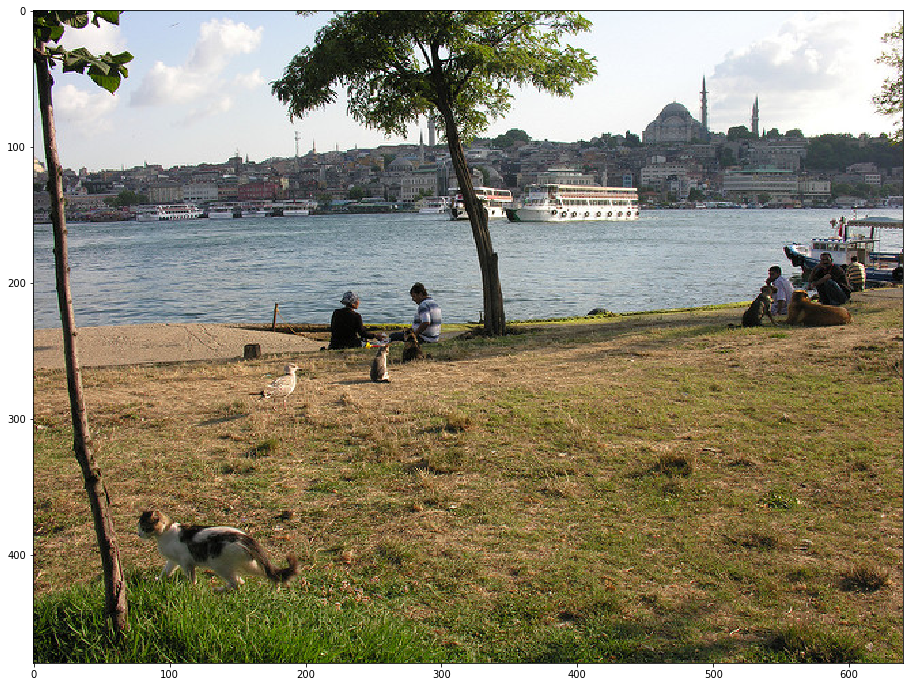

In [11]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
plt.imshow(image[:, :, [2, 1, 0]])

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

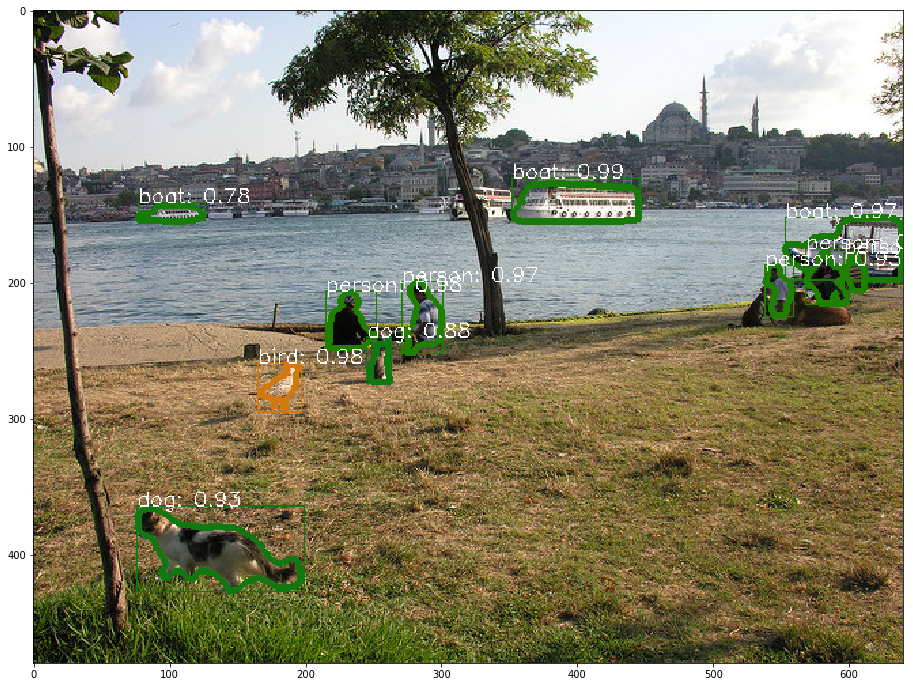

In [13]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
plt.imshow(predictions[:, :, [2, 1, 0]])

In [14]:
predictions.shape

(480, 640, 3)

In [15]:
pred = coco_demo.compute_prediction(image)
top_predictions = coco_demo.select_top_predictions(pred)

In [28]:
pred[:5]

BoxList(num_boxes=5, image_width=640, image_height=480, mode=xyxy)

In [16]:
def get_data_from_index(index):
    box = top_predictions.bbox[index]
    masks = top_predictions.get_field("mask")
    mask = masks[index][0, :, :]

    foreground_mask = np.zeros_like(image)
    foreground_mask[:,:,0] = foreground_mask[:,:,1] = foreground_mask[:,:,2] = masks[index][0, :, :]

    # background
    background_mask = np.ones_like(image) - foreground_mask
    
    return box, mask, foreground_mask, background_mask

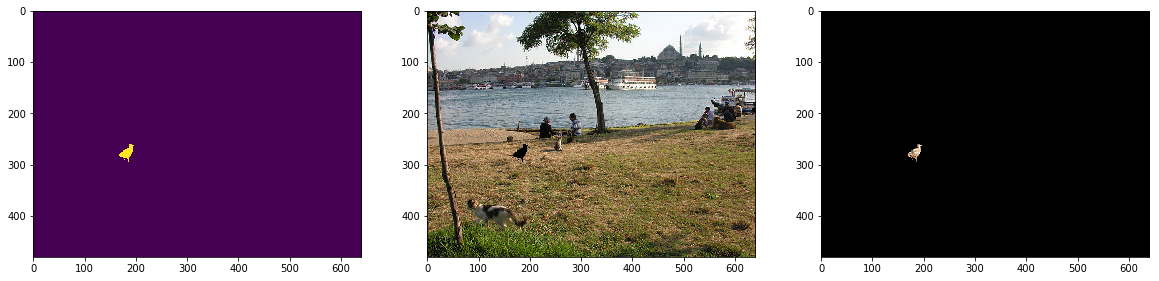

In [17]:
# example call and drawing
box, mask, foreground_mask, background_mask = get_data_from_index(1)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(mask)
background = background_mask * image
axarr[1].imshow(background[:, :, [2, 1, 0]])
foreground = foreground_mask * image
axarr[2].imshow(foreground[:, :, [2, 1, 0]])

In [18]:
def get_pivot_from_bounding_box(box):
    x1, y1, x2, y2 = np.floor(box.numpy())
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    
    pivot = ((x1 + x2)/2.0, y2)
    
    return pivot

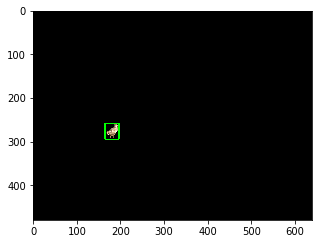

In [19]:
# drawing the bounding box on the image
x1, y1, x2, y2 = np.floor(box.numpy())
x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

box_prediction = foreground.copy()
cv2.rectangle(box_prediction,(x1, y1),(x2,y2),(0,255,0),2);

plt.figure(figsize=(5,5))
plt.imshow(box_prediction[:, :, [2, 1, 0]])

In [20]:
def get_point_dict_from_foreground_image(foreground):
    # create a dictionary of points with pixel values
    point_dict = {}
    for y in range(len(foreground)):
        for x in range(len(foreground[0])):
            if np.sum(foreground[y, x, :]) != 0:
                point_dict[(x,y)] = foreground[y, x, :]
    return point_dict

In [21]:
def get_permuted_points(points, dist):
    new_points = {}
    # shift to the right by one
    for key, value in points.items():
        new_points[(key[0]+dist,key[1])] = value
    return new_points

In [22]:
def draw_dict_on_image(current_image, points):
    for key, value in points.items():
        # y, x, :
        try:
            current_image[key[1], key[0], :] = points[key]
        except:
            print("out of bounds")

In [23]:
# take the background image
current_image = background.copy()

images = []
# mean_channel_1 = np.mean(background_image[])

for i in range(2):
    
    print(i)
    
    # draw the points
    current_image = image.copy()
    
    point_dicts_to_draw = []
    
    # the masks that we care about applying transformation to
    for index in range(len(top_predictions[:1])):
        
        box, mask, foreground_mask, background_mask = get_data_from_index(index)
        
        # get rid of the thing to be drawn this time
        current_image *= background_mask # okay
        
        point_dict = get_point_dict_from_foreground_image(foreground_mask * image) # okay
        pivot = get_pivot_from_bounding_box(box) # okay
        points = rotate_around_pivot(point_dict, pivot, i*10)
        point_dicts_to_draw.append(points) # okay

    for points in point_dicts_to_draw:
        draw_dict_on_image(current_image, points)
    
    images.append(current_image[:, :, [2, 1, 0]])
#     plt.imshow(current_image[:, :, [2, 1, 0]])
#     plt.show()

0
1


In [26]:
import imageio
imageio.mimsave('/home/ethanweber/Desktop/mygif.gif', images)